In [1]:
from models.twopartslstmautoencoder import LSTMAutoencoder
from utils.loaders import SigGenDatasetSplit
from utils.trainers import BaseTrainer, TwoStepTrainer
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob

In [2]:
files = []
for file in glob.glob("SigGen/*.mat"):
    files.append(str(file))
    
files.sort()

In [3]:
model = LSTMAutoencoder(input_dim=1,latent_dim=128, num_layers=4, seq_length=5000).to("cuda")
dataset = SigGenDatasetSplit(files, phase = "train")
trainers = BaseTrainer(model)

In [4]:
# model = trainers._train(train_loader = dataset, num_epochs = 10, loss_function=torch.nn.MSELoss())
model.load_state_dict(torch.load("2_step_weights_start.pt"))

<All keys matched successfully>

In [5]:
torch.save(model.state_dict(), "2_step_weights_start.pt")

In [6]:
# latent, target = trainers.extract_latent(dataset)

In [16]:
means = []

for i in range(4):
    means.append(latent[target == i])
    means[-1] = np.mean(means[-1], axis=0)

In [8]:
encoder = model.encoder

In [17]:
dataset_new = SigGenDatasetSplit(files, phase = "train", means = means)
trainers_new = TwoStepTrainer(encoder)

In [25]:
# encoder = trainers_new._train2(train_loader = dataset_new, num_epochs = 10, loss_function=torch.nn.MSELoss())
encoder.load_state_dict(torch.load("2_step_weights_1.pt"))

<All keys matched successfully>

In [20]:
# torch.save(encoder.state_dict(), "2_step_weights_2.pt")

In [26]:
dataset_test = SigGenDatasetSplit(files, phase = "test")

latent, target = trainers_new.extract_latent(dataset_test)

Time : 16.866720853024162


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import pandas as pd

# Load or create your dataset
# Replace this with your actual data loading

# Initialize and fit k-Means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent)

# Create a confusion matrix to evaluate clustering performance
# We need to compute a mapping between cluster labels and true labels
# First, create a confusion matrix to find out how clusters are mapped to true labels
conf_matrix = confusion_matrix(target, clusters)

# Find the optimal permutation of cluster labels to match true labels
from scipy.optimize import linear_sum_assignment

# Solve the linear sum assignment problem
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Re-map clusters to the true labels
cluster_to_label = dict(zip(col_ind, row_ind))

# Map clusters to labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in clusters])

# Compute accuracy
accuracy = accuracy_score(target, y_pred_mapped)
print(f"Cluster Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.56


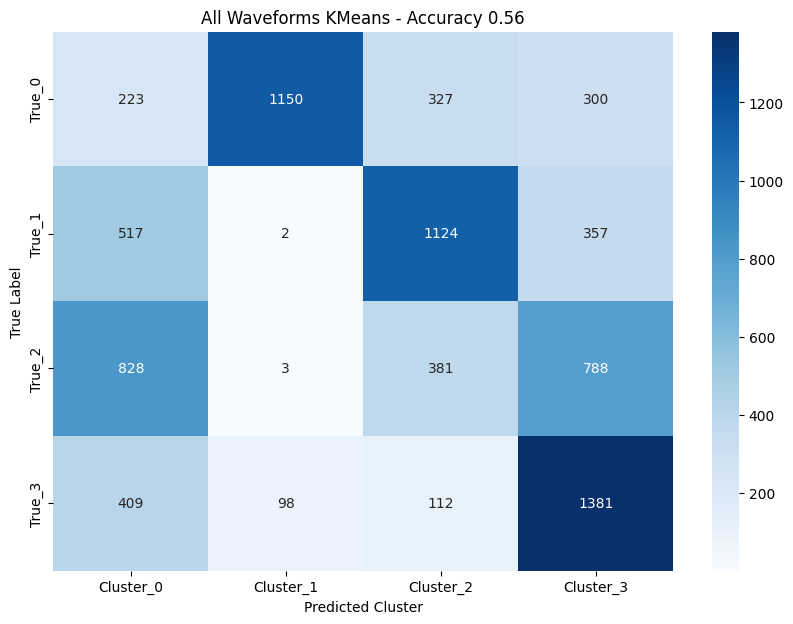

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=[f'True_{i}' for i in range(conf_matrix.shape[0])],
                              columns=[f'Cluster_{i}' for i in range(conf_matrix.shape[1])])


# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'All Waveforms KMeans - Accuracy {accuracy:.2f}')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')

file_path = os.path.join('confusion_matrix', "all_confusion_matrix_heatmap_2step_1_test.png")

plt.savefig(file_path, dpi=300)

plt.show()